# Supervised training with RANS

In [1]:
%reset -f

In [2]:
import numpy as np
import os.path, random

# import torch
# from torch.utils.data import Dataset
# print("Torch version {} ".format(torch.__version__))

# get training data
os.makedirs("./temp/", exist_ok=True)
dir = "./temp/"
if True:
    # download
    if not os.path.isfile(dir+'data-airfoils.npz'):
        import requests
        print("Downloading training data (300MB), this can take a few minutes the first time...")
        with open(dir+"data-airfoils.npz", 'wb') as datafile:
            resp = requests.get('https://dataserv.ub.tum.de/s/m1615239/download?path=%2F&files=dfp-data-400.npz', verify=False)
            datafile.write(resp.content)
else:
    # alternative: load from google drive (upload there beforehand):
    from google.colab import drive
    drive.mount('/content/gdrive')
    dir = "./gdrive/My Drive/"

npfile=np.load(dir+'data-airfoils.npz', allow_pickle=True)
print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))
print("Size of the inputs array: "+format(npfile["inputs"].shape))

Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


Stats 0 : [-0.3255776199086798, 0.23393399824079095, 0.47048169549735686]
Stats 1 : [-0.6548143700240462, 0.017164150495987723, 0.8552243695079386]
Stats 2 : [-0.5325950274411584, -0.04987998400700594, 1.0]


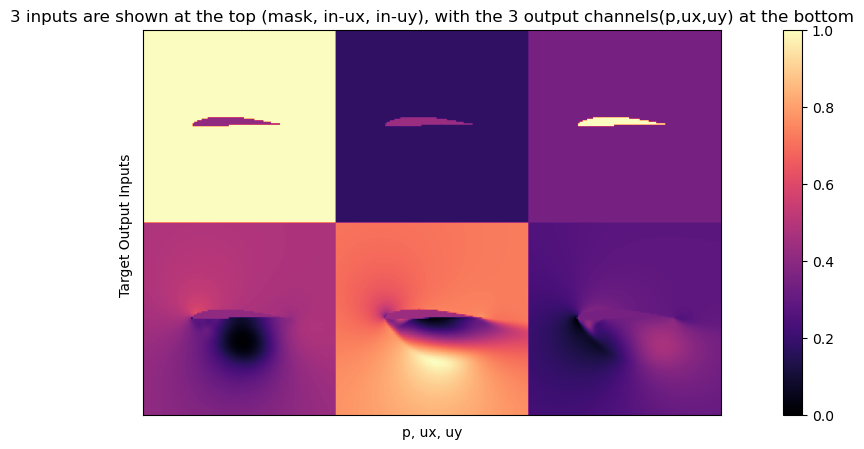

In [3]:
import pylab
# helper to show three target channels: normalized, with colormap, side by side
def showSbs(a1,a2, stats=False, bottom="NN Output", top="Reference", title=None):
    c=[]
    for i in range(3):
        b = np.flipud( np.concatenate((a2[i],a1[i]),axis=1).transpose())
        min, mean, max = np.min(b), np.mean(b), np.max(b);
        if stats: print("Stats %d : "%i + format([min,mean,max]))
        b -= min; b /= (max-min)
        c.append(b)
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    axes.set_xticks([]); axes.set_yticks([]);
    im = axes.imshow(np.concatenate(c,axis=1), origin='upper', cmap='magma')

    pylab.colorbar(im); pylab.xlabel('p, ux, uy'); pylab.ylabel('%s %s '%(bottom,top))
    if title is not None: pylab.title(title)

NUM=72
showSbs(npfile["inputs"][NUM],npfile["targets"][NUM], stats=True, bottom="Target Output", top="Inputs", title="3 inputs are shown at the top (mask, in-ux, in-uy), with the 3 output channels(p,ux,uy) at the bottom")

In [4]:
# some global training constants
# number of training epochs
EPOCHS = 100
# batch size
BATCH_SIZE = 10
# learning rate
LR = 0.00002

class DfpDataset():
    def __init__(self, inputs,targets):
        self.inputs = inputs
        self.targets = targets
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
tdata = DfpDataset(npfile["inputs"], npfile["targets"])
vdata = DfpDataset(npfile["vinputs"], npfile["vtargets"])

from torch.utils.data import DataLoader
from utility_functions import numpy_collate_fn
trainLoader = DataLoader(tdata, collate_fn=numpy_collate_fn, batch_size=BATCH_SIZE, shuffle=True , drop_last=True)
valiLoader = DataLoader(vdata, collate_fn=numpy_collate_fn, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print("Training & validation batches: {} , {} ".format(len(trainLoader),len(valiLoader) ))

Training & validation batches: 32 , 8 
